# Visualizations and double checks for stimulus generation

This notebook should serve to document the key features of the stimulus that we generate

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np

## Simulus design key features to consider

1. We must do the rotation correctly, so that they all have the same frequency
2. We must center the grating on a peak (or valley) so that all angles have the same behavior around the center
3. We want the mean luminance of the stimuli to be constant in angle.
    - this can be achieved only up to the pixel discritization, so it depends on the resolution
    - in turn, the level of discritization error is also dependent on the frequency of the grating
        * but this will be aliased by the sampling, so workable frequencies are still set by the resolution


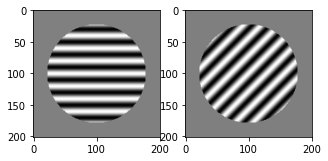

In [211]:
def getGrating(freq, theta, pixelDim=201):
    xs = np.linspace(-np.pi, np.pi, pixelDim)
    ys = np.linspace(-np.pi, np.pi, pixelDim)

    X, Y = np.meshgrid(xs, ys)
    Z = np.cos( freq * (Y*np.cos(theta) + X*np.sin(theta) ) )
    
    r2 = X**2 + Y**2
    Z[r2 >= 6] = 0
    
    return Z
    

Z1 = getGrating(10, 0, 201)
Z2 = getGrating(10, np.pi/4, 201)

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(2*Z1-1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(2*Z2-1, cmap='gray')

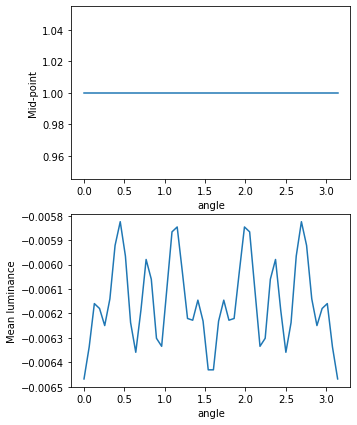

In [181]:
angles = np.linspace(0, np.pi, 50)

zeroPoint = []
means = []

for angle in angles:
    image = getGrating(10, angle, 201)
    means.append( np.mean(image) )
    
    zeroPoint.append(image[100,100])


figsize(5,7)  
plt.subplots(2,1)
plt.subplot(2,1,1)
plt.plot(angles, np.array(zeroPoint))
plt.ylabel('Mid-point') 
plt.xlabel('angle') 

plt.subplot(2,1,2)
plt.plot(angles, np.array(means))
plt.xlabel('angle') 
plt.ylabel('Mean luminance');



## grating overlap as a means of assessing angle

In [188]:
def findOverlap(grating1, grating2):
    return np.sum(grating1*grating2)
    
    

In [206]:
baseline = getGrating(10, np.pi/2)
angles = np.linspace(np.pi/2-0.001, np.pi/2+0.001, 300)

overlaps = []
for angle in angles:
    experimental = getGrating(10, angle)
    overlaps.append( findOverlap( baseline, experimental)  )
    

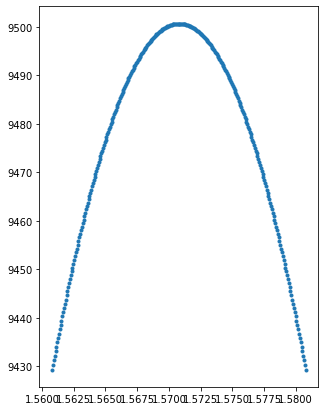

In [205]:
plt.plot(angles, np.array(overlaps), '.')

In [265]:
def searchForAngle(targetGrating, endpoints, targetResolution, makeGrating):
    """Perform repeatedly search for the max angle"""
    angles = np.linspace(endpoints[0], endpoints[1], 20)
    
    overlaps = []
    for angle in angles:
        test = makeGrating(angle)
        overlaps.append( findOverlap( targetGrating, test)  )
    
    maxInd = np.argmax( np.array(overlaps) )
    
    if endpoints[1] - endpoints[0] < targetResolution:
        return angles[maxInd]
    
    nextMin = angles[ max( maxInd-1, 0) ]
    nextMax = angles[ min( maxInd+1, len(angles)-1) ]
    
    return searchForAngle(targetGrating, [ nextMin, nextMax ] , targetResolution, makeGrating)
    
    
    
    

In [268]:
searchForAngle(getGrating(10, np.pi*3/4), [0, np.pi], 1E-5, lambda angle: getGrating(10, angle))

2.3561944857991075

In [272]:
from stimulusGeneration import generateGrating

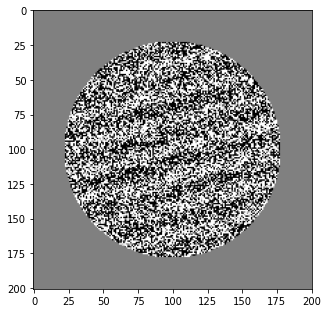

In [302]:
testimg = generateGrating(10, 0.25, shotNoise=1., noiseVar=10)
plt.imshow( testimg, cmap='gray' )

In [306]:
searchForAngle(testimg, [0, np.pi], 1E-10, lambda angle: getGrating(10, angle))

0.2487592373613703